In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import copy

img = cv2.imread('sar_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [2]:
# Гауссовский шум
def add_gaussian_noise(image, sigma=100):
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

# Постоянный (равномерно распределённый)
def add_uniform_noise(image):
    noise = np.random.randint(0, 101, size=image.shape[:2])   
    noise = noise.astype(np.int16) - 50                       
    noisy = image.astype(np.int16) + noise[..., np.newaxis]   
    return np.clip(noisy, 0, 255).astype(np.uint8)

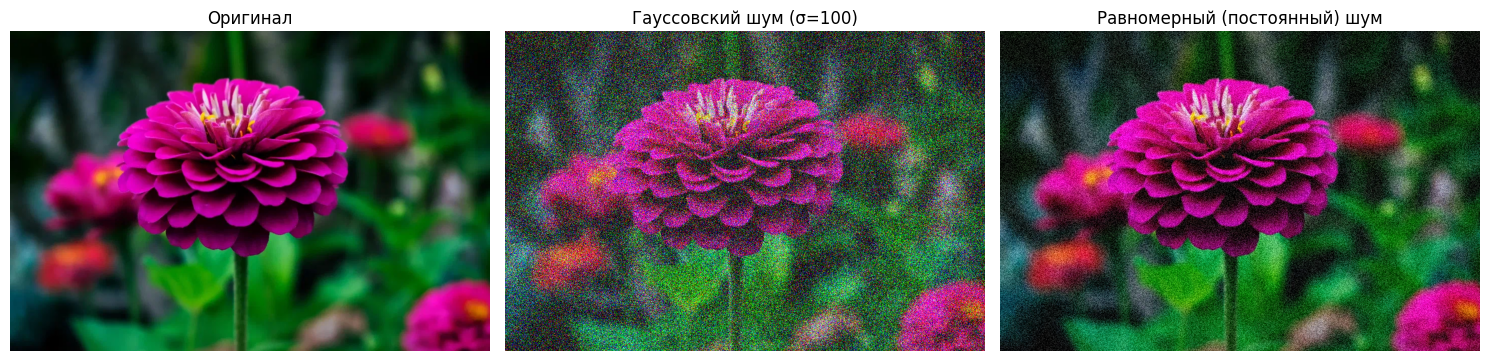

In [3]:
gauss_img = add_gaussian_noise(img, sigma=100)
uniform_img = add_uniform_noise(img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Оригинал')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gauss_img)
plt.title('Гауссовский шум (σ=100)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(uniform_img)
plt.title('Равномерный (постоянный) шум')
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def apply_all_filters(noisy_img):
    filters = {}
    
    # Медианный
    filters['Медианный 3×3'] = cv2.medianBlur(noisy_img, 3)
    filters['Медианный 5×5'] = cv2.medianBlur(noisy_img, 5)
    filters['Медианный 7×7'] = cv2.medianBlur(noisy_img, 7)
    
    # Гауссов
    filters['Гаусс 3×3'] = cv2.GaussianBlur(noisy_img, (3,3), 0)
    filters['Гаусс 5×5'] = cv2.GaussianBlur(noisy_img, (5,5), 1)
    filters['Гаусс 7×7'] = cv2.GaussianBlur(noisy_img, (7,7), 2)
    
    # Билатеральный
    filters['Билатеральный (d=9, σ=75)'] = cv2.bilateralFilter(noisy_img, 9, 75, 75)
    filters['Билатеральный (d=15, σ=100)'] = cv2.bilateralFilter(noisy_img, 15, 100, 100)
    filters['Билатеральный (d=15, σ=150)'] = cv2.bilateralFilter(noisy_img, 15, 150, 150)
    
    # Нелокальные средние
    filters['NLM (h=10)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 10, 10, 7, 21)
    filters['NLM (h=20)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 20, 20, 7, 21)
    filters['NLM (h=30)'] = cv2.fastNlMeansDenoisingColored(noisy_img, None, 30, 30, 7, 21)
    
    return filters

gauss_filters = apply_all_filters(gauss_img)
uniform_filters = apply_all_filters(uniform_img)

In [5]:
def calculate_metrics(original, filtered):
    p = psnr(original, filtered)
    s = ssim(original, filtered, channel_axis=-1, data_range=255)
    return p, s

# Метрики зашумлённых изображений
psnr_gauss_noise, ssim_gauss_noise = calculate_metrics(img, gauss_img)
psnr_uniform_noise, ssim_uniform_noise = calculate_metrics(img, uniform_img)

print("МЕТРИКИ ЗАШУМЛЁННЫХ ИЗОБРАЖЕНИЙ:")
print(f"Гауссовский шум:         PSNR = {psnr_gauss_noise:.2f} дБ, SSIM = {ssim_gauss_noise:.4f}")
print(f"Равномерный (постоянный): PSNR = {psnr_uniform_noise:.2f} дБ, SSIM = {ssim_uniform_noise:.4f}")

МЕТРИКИ ЗАШУМЛЁННЫХ ИЗОБРАЖЕНИЙ:
Гауссовский шум:         PSNR = 10.73 дБ, SSIM = 0.0290
Равномерный (постоянный): PSNR = 19.78 дБ, SSIM = 0.1564


In [6]:
def get_top_results(original, filters_dict, top_n=5):
    results = []
    for name, filtered in filters_dict.items():
        p, s = calculate_metrics(original, filtered)
        results.append((name, p, s, filtered))
    results.sort(key=lambda x: x[2], reverse=True)  # сортировка по SSIM
    return results[:top_n]

top_gauss = get_top_results(img, gauss_filters, 5)
top_uniform = get_top_results(img, uniform_filters, 5)

print("\nТОП-5 ФИЛЬТРОВ ПО SSIM")
print("\nГАУССОВСКИЙ ШУМ:")
for i, (name, p, s, _) in enumerate(top_gauss, 1):
    print(f"{i}. {name:<30} PSNR: {p:6.2f} дБ SSIM: {s:.4f}")

print("\nРАВНОМЕРНЫЙ (ПОСТОЯННЫЙ) ШУМ:")
for i, (name, p, s, _) in enumerate(top_uniform, 1):
    print(f"{i}. {name:<30} PSNR: {p:6.2f} дБ SSIM: {s:.4f}")


ТОП-5 ФИЛЬТРОВ ПО SSIM

ГАУССОВСКИЙ ШУМ:
1. Гаусс 7×7                      PSNR:  18.95 дБ SSIM: 0.3886
2. Медианный 7×7                  PSNR:  23.37 дБ SSIM: 0.3798
3. Медианный 5×5                  PSNR:  21.04 дБ SSIM: 0.2448
4. Гаусс 5×5                      PSNR:  17.79 дБ SSIM: 0.1886
5. Гаусс 3×3                      PSNR:  16.81 дБ SSIM: 0.1287

РАВНОМЕРНЫЙ (ПОСТОЯННЫЙ) ШУМ:
1. Гаусс 7×7                      PSNR:  29.52 дБ SSIM: 0.7356
2. Медианный 7×7                  PSNR:  29.96 дБ SSIM: 0.7128
3. NLM (h=30)                     PSNR:  27.26 дБ SSIM: 0.6485
4. Медианный 5×5                  PSNR:  28.43 дБ SSIM: 0.5841
5. Гаусс 5×5                      PSNR:  28.33 дБ SSIM: 0.5799


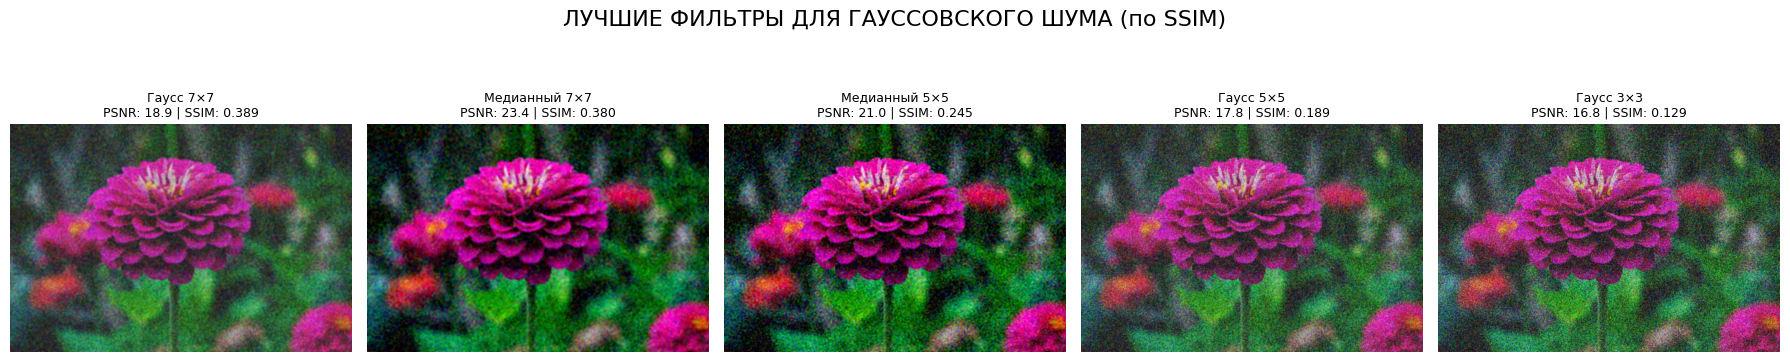

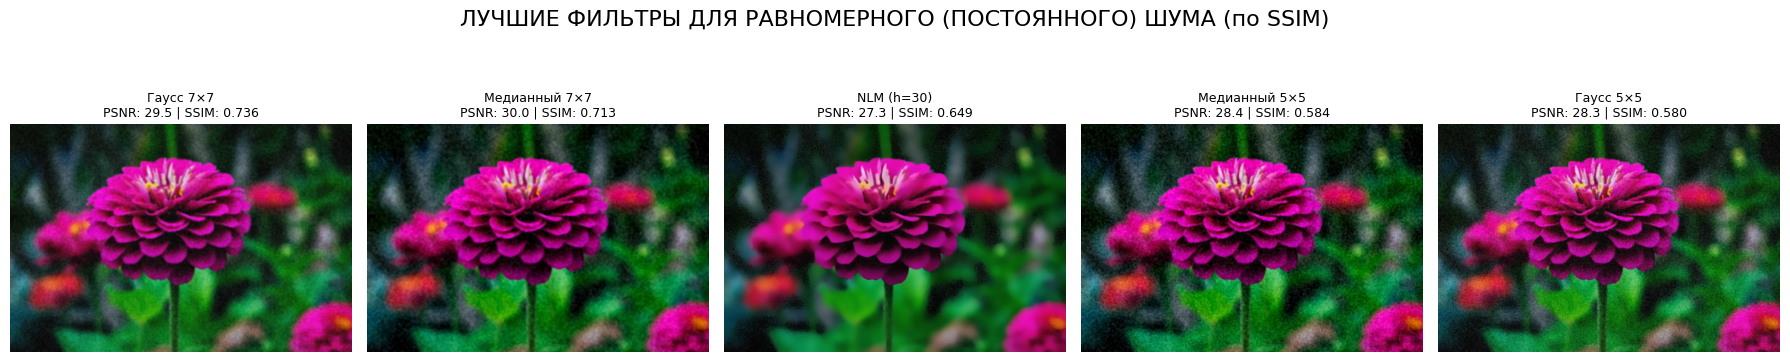

In [7]:
# Гауссовский шум
plt.figure(figsize=(18, 8))
plt.suptitle('ЛУЧШИЕ ФИЛЬТРЫ ДЛЯ ГАУССОВСКОГО ШУМА (по SSIM)', fontsize=16, y=0.98)
for i, (name, p, s, filtered) in enumerate(top_gauss, 1):
    plt.subplot(2, 5, i)
    plt.imshow(filtered)
    plt.title(f'{name}\nPSNR: {p:.1f} | SSIM: {s:.3f}', fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Равномерный (постоянный) шум
plt.figure(figsize=(18, 8))
plt.suptitle('ЛУЧШИЕ ФИЛЬТРЫ ДЛЯ РАВНОМЕРНОГО (ПОСТОЯННОГО) ШУМА (по SSIM)', fontsize=16, y=0.98)
for i, (name, p, s, filtered) in enumerate(top_uniform, 1):
    plt.subplot(2, 5, i)
    plt.imshow(filtered)
    plt.title(f'{name}\nPSNR: {p:.1f} | SSIM: {s:.3f}', fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()